In [1]:
# !pip install netCDF4
# !pip install cartopy
# !pip install geopandas rasterio rioxarray

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

In [3]:
# Define the folder containing the netCDF files
data_folder = r'E:\Career\Academic\M.Sc Data\2. October 2023\Data\CMIP6\netCDF\Tmax\MRI'

################################################################################################################################
# shapefile = gpd.read_file(r'E:\Career\Academic\M.Sc Data\2. October 2023\Data\CMIP5\Shapefiles\Dhaka_Division.shp')
shapefile = gpd.read_file(r'E:\Career\Academic\M.Sc Data\2. October 2023\Data\CMIP5\Shapefiles\Chattogram_Division.shp')
################################################################################################################################

# List all netCDF files (assuming filenames start with "tasmax_day_MRI-ESM2-0_hist-sol_r1i1p1f1_gn_")
filenames = [f for f in os.listdir(data_folder) if f.startswith('tasmax_day_MRI-ESM2-0_hist-sol_r1i1p1f1_gn_')]


# Empty variable to store merged data
merged_data = None

for filename in filenames:
  # Construct full path for each file
  file_path = os.path.join(data_folder, filename)

  # Load the entire dataset (less efficient)
  data = xr.open_dataset(file_path)

  # Select specific variables (lon, lat, tasmax)
  data = data[['lon', 'lat', 'tasmax']]  # Using list comprehension for selection
  

  # # Load and clip data using existing logic
  # data = xr.open_dataset(file_path)

    
  data = data.rename({'lon': 'x', 'lat': 'y'})
  data.rio.write_crs(shapefile.crs, inplace=True)
  clipped = data.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs)

  # Check if it's the first file (for initialization)
  if merged_data is None:
    merged_data = clipped
  else:
    # Merge data along the time dimension (assuming 'time' exists)
    merged_data = xr.concat([merged_data, clipped], dim='time')

# Print the final merged data
print(merged_data)


<xarray.Dataset> Size: 830kB
Dimensions:      (x: 2, y: 3, time: 25933)
Coordinates:
  * x            (x) float64 16B 91.12 92.25
  * y            (y) float64 24B 21.87 22.99 24.11
  * time         (time) datetime64[ns] 207kB 1950-01-01T12:00:00 ... 2020-12-...
    height       float64 8B 2.0
    spatial_ref  int32 4B 0
Data variables:
    tasmax       (time, y, x) float32 622kB nan 294.7 296.3 ... 295.7 295.5 nan
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DAMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-02T19:18:54Z
    ...                     ...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/fd29fcc5-

In [4]:
###############################################################
# merged_data["pr"] = merged_data["pr"]*86400
merged_data["tasmax"] = merged_data["tasmax"]-273.15

In [5]:
merged_data["tasmax"][154,:]

<xarray.DataArray 'tasmax' (y: 3, x: 2)> Size: 24B
array([[      nan, 36.17868 ],
       [40.8255  , 36.398376],
       [39.647736,       nan]], dtype=float32)
Coordinates:
  * x            (x) float64 16B 91.12 92.25
  * y            (y) float64 24B 21.87 22.99 24.11
    time         datetime64[ns] 8B 1950-06-04T12:00:00
    height       float64 8B 2.0
    spatial_ref  int32 4B 0

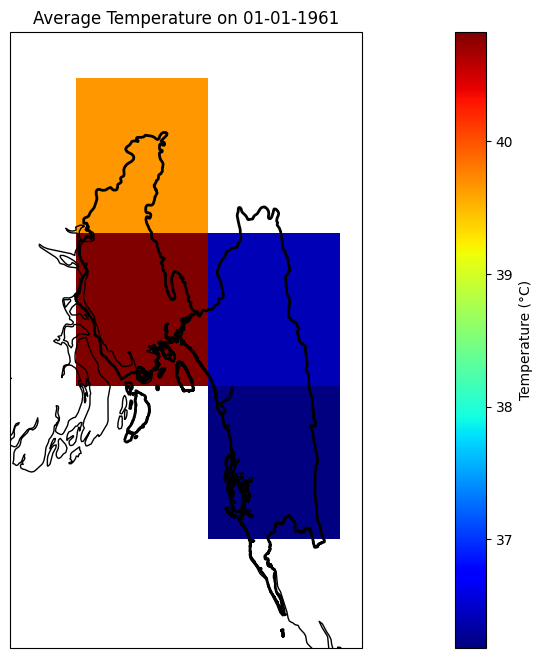

In [6]:
# Extract the temperature variable
tasmax = merged_data['tasmax']  # adjust 'tasmax' if it is named differently in your dataset

# Extract longitude and latitude
lon = merged_data['x']  # adjust 'lon' if it is named differently
lat = merged_data['y']  # adjust 'lat' if it is named differently

# Example setup
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})
ax.coastlines()

###################################################################################################################
# Min long, Max long, Min lat, Max lat
# ax.set_extent([89, 91.5, 22.5, 25])  # Dhaka
ax.set_extent([90, 93, 20.5, 25])  # Chattogram
#################################################################################################################


# Detects range automatically
# Creating a pcolormesh plot with a color map
temperature_plot = ax.pcolormesh(lon, lat, tasmax[154, :, :], transform=ccrs.PlateCarree(), cmap='jet')

# Adding the shapefile to the map
shapefile.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, transform=ccrs.PlateCarree())


# Adding a colorbar with customized padding and aspect ratio
cbar = fig.colorbar(temperature_plot, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Temperature (°C)')  # Adding a label to the colorbar

ax.set_title('Average Temperature on 01-01-1961')

plt.show()


# Location-wise mean

In [7]:
# Calculate the mean temperature for each location over time
mean_data = merged_data['tasmax'].mean(dim='time')

# Print the result
print(mean_data)

<xarray.DataArray 'tasmax' (y: 3, x: 2)> Size: 24B
array([[      nan, 28.7481  ],
       [31.393042, 28.867893],
       [31.028238,       nan]], dtype=float32)
Coordinates:
  * x            (x) float64 16B 91.12 92.25
  * y            (y) float64 24B 21.87 22.99 24.11
    height       float64 8B 2.0
    spatial_ref  int32 4B 0


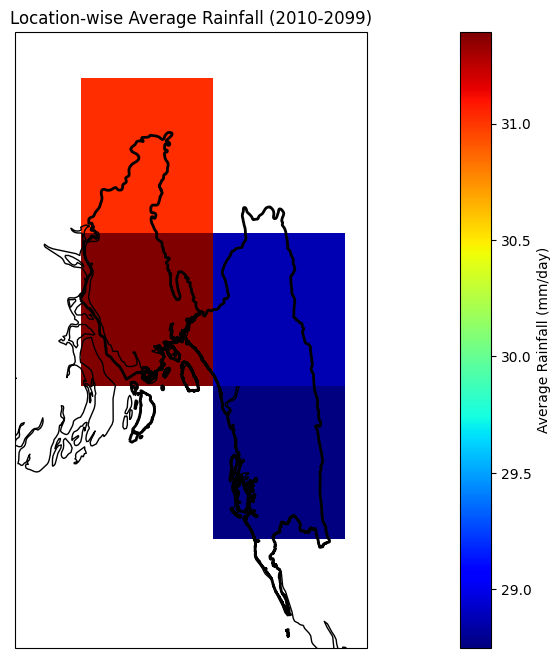

In [8]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})
ax.coastlines()

###################################################################################################################
# Min long, Max long, Min lat, Max lat
# ax.set_extent([89, 91.5, 22.5, 25])  # Dhaka
ax.set_extent([90, 93, 20.5, 25])  # Chattogram
#################################################################################################################

# Plot the mean temperature
temperature_plot = ax.pcolormesh(mean_data['x'], mean_data['y'], mean_data, transform=ccrs.PlateCarree(), cmap='jet')

# Adding the shapefile to the map
shapefile.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, transform=ccrs.PlateCarree())

# Adding a colorbar with customized padding and aspect ratio
cbar = fig.colorbar(temperature_plot, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Average Rainfall (mm/day)')

ax.set_title('Location-wise Average Rainfall (2010-2099)')

plt.show()


# Spatial Trend

In [9]:
# Assuming merged_data is your xarray.Dataset already loaded with data

# Prepare the time variable in years since the start date
time_in_years = (merged_data['time'] - merged_data['time'][0]).dt.days / 365.25

# Initialize an empty DataArray to store the slopes, matching the spatial dimensions
slopes = xr.full_like(merged_data['tasmax'].isel(time=0), np.nan)

# Use 'sizes' instead of 'dims' to get the dimensions' size
y_dim = merged_data.sizes['y']
x_dim = merged_data.sizes['x']

# Iterate over each spatial location by index
for yi in range(y_dim):
    for xi in range(x_dim):
        # Get the temperature data for this location
        temp_data = merged_data['tasmax'].isel(x=xi, y=yi)

        # Check for enough non-NaN data
        if np.isfinite(temp_data).sum() > 1:
            # Perform linear regression
            coefficients = np.polyfit(time_in_years, temp_data, 1, full=False)
            slope = coefficients[0]  # slope of the line
            # Assign the slope to the correct location
            slopes[yi, xi] = slope

print(slopes)


<xarray.DataArray 'tasmax' (y: 3, x: 2)> Size: 24B
array([[        nan, -0.00506087],
       [-0.00393714, -0.00684449],
       [-0.00310456,         nan]], dtype=float32)
Coordinates:
  * x            (x) float64 16B 91.12 92.25
  * y            (y) float64 24B 21.87 22.99 24.11
    time         datetime64[ns] 8B 1950-01-01T12:00:00
    height       float64 8B 2.0
    spatial_ref  int32 4B 0


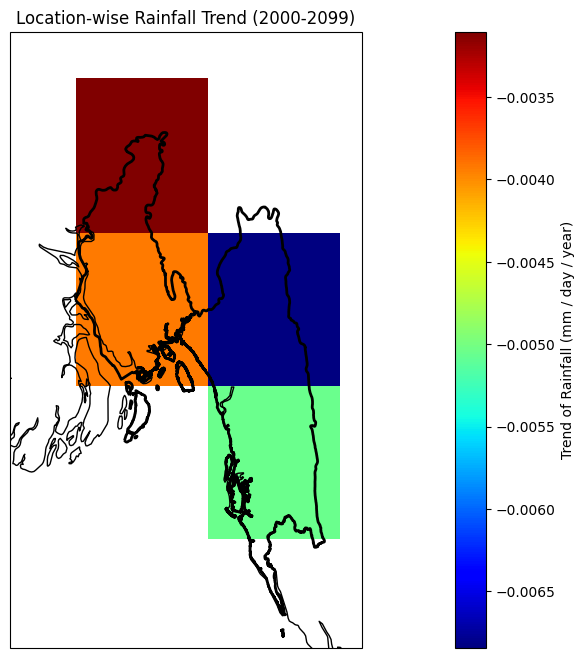

In [10]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.Mercator()})
ax.coastlines()

###################################################################################################################
# Min long, Max long, Min lat, Max lat
# ax.set_extent([89, 91.5, 22.5, 25])  # Dhaka
ax.set_extent([90, 93, 20.5, 25])  # Chattogram
#################################################################################################################

# Plot the mean temperature
temperature_plot = ax.pcolormesh(slopes['x'], slopes['y'], slopes, transform=ccrs.PlateCarree(), cmap='jet')

# Adding the shapefile to the map
shapefile.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, transform=ccrs.PlateCarree())

# Adding a colorbar with customized padding and aspect ratio
cbar = fig.colorbar(temperature_plot, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Trend of Rainfall (mm / day / year)')

ax.set_title('Location-wise Rainfall Trend (2000-2099)')

plt.show()


# Time Series

In [11]:
# Pivot table creation
pivot_table = merged_data.to_dataframe().reset_index()
pivot_table = pivot_table.pivot_table(index='time', columns=['y', 'x'], values='tasmax')

# Print or save the pivoted data
print(pivot_table)

# Optionally, save to CSV
pivot_table.to_csv('precipitation_time_series.csv')

y                     21.86905   22.99054              24.11203
x                       92.250     91.125     92.250     91.125
time                                                           
1950-01-01 12:00:00  21.536987  23.129486  21.372955  20.515259
1950-01-02 12:00:00  20.238159  19.859344  16.130280  19.777374
1950-01-03 12:00:00  18.882111  20.411499  17.773163  18.586700
1950-01-04 12:00:00  20.347107  21.928467  19.737305  19.600067
1950-01-05 12:00:00  20.828918  22.589874  20.144501  19.686523
...                        ...        ...        ...        ...
2020-12-27 12:00:00  23.037354  23.309509  22.802551  22.885101
2020-12-28 12:00:00  23.058655  23.445862  22.728210  23.064697
2020-12-29 12:00:00  22.729431  23.012848  22.189972  22.660278
2020-12-30 12:00:00  22.734406  22.936249  22.189392  22.422394
2020-12-31 12:00:00  23.198853  23.244629  22.566071  22.369385

[25933 rows x 4 columns]
